In [265]:
import mediapipe as mp
import cv2
import numpy as np
import pandas as pd
import functions
import csv
import os
from collections import deque


mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose


In [266]:
counter = 0
stage = None
minAngle = 180
maxAngle = 0
frame_counter = 0

#Set up different Joints. The value at index 1 is the middle of the joint
JOINTS_TO_TRACK = {
    "left_elbow": [mp_pose.PoseLandmark.LEFT_SHOULDER, mp_pose.PoseLandmark.LEFT_ELBOW, mp_pose.PoseLandmark.LEFT_WRIST],
    "right_elbow": [mp_pose.PoseLandmark.RIGHT_SHOULDER, mp_pose.PoseLandmark.RIGHT_ELBOW, mp_pose.PoseLandmark.RIGHT_WRIST],
    "left_knee": [mp_pose.PoseLandmark.LEFT_HIP, mp_pose.PoseLandmark.LEFT_KNEE, mp_pose.PoseLandmark.LEFT_ANKLE],
    "right_knee": [mp_pose.PoseLandmark.RIGHT_HIP, mp_pose.PoseLandmark.RIGHT_KNEE, mp_pose.PoseLandmark.RIGHT_ANKLE],
    "right_hip": [mp_pose.PoseLandmark.RIGHT_KNEE, mp_pose.PoseLandmark.RIGHT_HIP, mp_pose.PoseLandmark.RIGHT_SHOULDER],
    "left_hip": [mp_pose.PoseLandmark.LEFT_KNEE, mp_pose.PoseLandmark.LEFT_HIP, mp_pose.PoseLandmark.LEFT_SHOULDER],
    # Add more as needed
}


#initializes a map to store the x,y,z coordinate of each body part at each frame
landmark_positions = {}
for position in mp_pose.PoseLandmark:
    landmark_positions[position.value] = [[],[],[]]


#Stores the angles calculated at each frame in a different map
angle_history = {joint: [] for joint in JOINTS_TO_TRACK}

script_dir = os.path.dirname(os.path.abspath("main.ipynb"))

# Define the path to your videos folder relative to the script
videos_dir = os.path.join(script_dir, '..', 'videos')

# Normalize path just in case
videos_dir = os.path.normpath(videos_dir)

In [267]:
cap = cv2.VideoCapture()

for filename in os.listdir(videos_dir):
    if filename.endswith(('.mp4', '.avi', '.mov', 'mkv')):  # filter video files
        video_path = os.path.join(videos_dir, filename)
        cap = cv2.VideoCapture(video_path)
        print("video_path:", video_path)
        if not cap.isOpened():
            continue
        with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
            angle_windows = {}
            for joint_name in JOINTS_TO_TRACK.keys():
                angle_windows[joint_name] = deque([], maxlen=window_length)

            while cap.isOpened():

                window_length = 10

                angle_window = deque(maxlen=window_length)

                ret, frame = cap.read()




                if not ret:
                    dataDirectory = os.path.join(script_dir, '..', 'data')
                    points = {f"landmark_{k}": np.array(v) for k, v in landmark_positions.items()}
                    angles = {k: np.array(v) for k, v in angle_history.items()}
                    if filename.startswith("squat"):
                        np.savez(f"{dataDirectory}\squat files\squat points.npz", **points)
                        np.savez(f"{dataDirectory}\squat files\squat angles.npz", **angles)
                        functions.save_to_csv(angles, f"{dataDirectory}\squat files\squat angles.csv")
                    if filename.startswith("bench"):
                        np.savez(f"{dataDirectory}\\bench files\\bench points.npz", **points)
                        np.savez(f"{dataDirectory}\\bench files\\bench angles.npz", **angles)
                        functions.save_to_csv(angles, f"{dataDirectory}\\bench files\\bench angles.csv")
                    if filename.startswith("deadlift"):
                        np.savez(f"{dataDirectory}\\deadlift files\\deadlift points.npz", **points)
                        np.savez(f"{dataDirectory}\\deadlift files\\deadlift angles.npz", **angles)
                        #functions.save_to_csv(angles, f"{dataDirectory}\\deadlift files\\deadlift angles.csv")
                        #np.savetxt(f"{dataDirectory}\\deadlift files\\deadlift angles.csv", **angles, delimiter = ',')
                    break
                    




                #Recolor the frame to RGB
                image = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
                image.flags.writeable = False

                results = pose.process(image)

                #Recolor the frame back to BGR
                image.flags.writeable = True
                image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)


                #Extract Landmarks
                try:
                    landmarks = results.pose_landmarks.landmark
                    for position in mp_pose.PoseLandmark:
                        landmark = landmarks[position.value]
                        landmark_positions[position.value][0].append(round(landmark.x,2))
                        landmark_positions[position.value][1].append(round(landmark.y,2))
                        landmark_positions[position.value][2].append(round(landmark.z,2))

                    #GO THRU EACH JOINT GIVEN IN JOINTS_TO_TRACK
                    for joint_name, landmark_indices in JOINTS_TO_TRACK.items():
                        #INIT DEQUE TO TAKE THE AVERAGE OF DATA IN A "SLIDING WINDOW"
                        #HELPS TO SMOOTH THE DATA. Adjust Window Length to set smoothness
                        #of data
                        try:
                            a = landmarks[landmark_indices[0].value]
                            b = landmarks[landmark_indices[1].value]
                            c = landmarks[landmark_indices[2].value]

                            # Use only x, y for 2D analysis
                            angle = functions.calculate_angle(
                                [a.x, a.y, a.z],
                                [b.x, b.y, b.z],
                                [c.x, c.y, c.z]
                            )

                            angle_windows[joint_name].append(angle)
                            if len(angle_windows[joint_name]) == window_length:
                                rolling_avg = np.mean(angle_windows[joint_name])
                                angle_history[joint_name].append(int(rolling_avg))

                            cv2.putText(image, f"{str(round(a.x,2))}  {str(round(a.y,2))} {str(round(a.z,2))}",
                                np.multiply([a.x, a.y], [cap.get(cv2.CAP_PROP_FRAME_WIDTH),cap.get(cv2.CAP_PROP_FRAME_HEIGHT)]).astype(int), cv2.FONT_HERSHEY_SIMPLEX,
                                0.5, (255,255,255), 2, cv2.LINE_AA)
                        except Exception:
                            angle = np.nan


                        #Gather less data points by storing them every 5 frames
                        '''if int(cap.get(cv2.CAP_PROP_POS_FRAMES)) % 5 == 0:
                            print(cap.get(cv2.CAP_PROP_POS_FRAMES))
                            angle_history[joint_name].append(int(angle))'''

                        if not np.isnan(angle):
                            b_coords = np.multiply([b.x, b.y], [image.shape[1], image.shape[0]]).astype(int)
                            cv2.putText(
                                image,
                                f"{joint_name}: {int(angle)}",
                                tuple(b_coords),
                                cv2.FONT_HERSHEY_SIMPLEX,
                                0.5,
                                (255,255,255),
                                2,
                                cv2.LINE_AA
                            )

                except:
                    pass


                mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                          mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2),
                                          mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                          )

                cv2.imshow('Mediapipe Feed',image)


                if cv2.waitKey(10) & 0xFF == ord('q'):
                    print("User requested exit.")
                    break  # End loop when user presses 'q'



            points = {f"landmark_{k}": np.array(v) for k, v in landmark_positions.items()}
            angles = {k:np.array(v) for k, v in angle_history.items()}

            np.savez("points.npz", **points)
            np.savez("angles.npz", **angles)
            #np.savetxt('angles.csv', angles, delimiter = ',')
            cv2.destroyAllWindows()

    cap.release()
    cv2.destroyAllWindows()

video_path: C:\Users\alexk\PycharmProjects\SeniorProject\videos\deadlift 1.mp4
User requested exit.
video_path: C:\Users\alexk\PycharmProjects\SeniorProject\videos\deadlift 2.mkv
video_path: C:\Users\alexk\PycharmProjects\SeniorProject\videos\squat 1.mp4
User requested exit.


In [268]:
#DATA VISUALIZATION

import numpy as np

data = np.load(r"C:\Users\alexk\PycharmProjects\SeniorProject\data\squat files\squat points.npz")

#format: x,y,z: coordinates for each. divide by 60 to find how long recording is
for key in data.files:
    print(key, data[key].shape)

#maps each body position to its index defined my MediaPipe
index_to_name = {str(i): landmark.name for i, landmark in enumerate(mp_pose.PoseLandmark)}

# Print the landmark name and a few values
for key in data.files:

    idx = key.split('_')[-1]  # Extracts index from landmark, key is always last digit or digits
    name = index_to_name.get(idx, f"Unknown({idx})")
    #displays the Name of the body part, the key associated with it (e.g. landmark 5), and the last 5
    #values of x,y,z for that landmark
    print(f"{name} ({key}):" + "\n" + f"{data[key][:, :5]}")

angles = np.load(r"C:\Users\alexk\PycharmProjects\SeniorProject\data\squat files\squat angles.npz")
for key in angles:
    print(key, angles[key])

#Very easy to see when a rep is at the bottom versus at the top.
for key in data:
    print(key, data[key])

landmark_0 (3, 1095)
landmark_1 (3, 1095)
landmark_2 (3, 1095)
landmark_3 (3, 1095)
landmark_4 (3, 1095)
landmark_5 (3, 1095)
landmark_6 (3, 1095)
landmark_7 (3, 1095)
landmark_8 (3, 1095)
landmark_9 (3, 1095)
landmark_10 (3, 1095)
landmark_11 (3, 1095)
landmark_12 (3, 1095)
landmark_13 (3, 1095)
landmark_14 (3, 1095)
landmark_15 (3, 1095)
landmark_16 (3, 1095)
landmark_17 (3, 1095)
landmark_18 (3, 1095)
landmark_19 (3, 1095)
landmark_20 (3, 1095)
landmark_21 (3, 1095)
landmark_22 (3, 1095)
landmark_23 (3, 1095)
landmark_24 (3, 1095)
landmark_25 (3, 1095)
landmark_26 (3, 1095)
landmark_27 (3, 1095)
landmark_28 (3, 1095)
landmark_29 (3, 1095)
landmark_30 (3, 1095)
landmark_31 (3, 1095)
landmark_32 (3, 1095)
NOSE (landmark_0):
[[ 0.52  0.52  0.52  0.52  0.52]
 [ 0.58  0.57  0.57  0.58  0.58]
 [-0.38 -0.41 -0.4  -0.38 -0.4 ]]
LEFT_EYE_INNER (landmark_1):
[[ 0.52  0.52  0.52  0.52  0.52]
 [ 0.57  0.56  0.56  0.57  0.57]
 [-0.38 -0.42 -0.41 -0.39 -0.41]]
LEFT_EYE (landmark_2):
[[ 0.53  0.53

In [269]:
'''import os
import cv2

# Get the directory where this script is located
script_dir = os.path.dirname(os.path.abspath('__file__'))

# Define the path to your videos folder relative to the script
videos_dir = os.path.join(script_dir, '..', 'videos')

# Normalize path just in case
videos_dir = os.path.normpath(videos_dir)

# Loop over all files in the videos directory
for filename in os.listdir(videos_dir):
    if filename.endswith(('.mp4', '.avi', '.mov')):  # filter video files
        video_path = os.path.join(videos_dir, filename)
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            continue

        cap.release()'''


"import os\nimport cv2\n\n# Get the directory where this script is located\nscript_dir = os.path.dirname(os.path.abspath('__file__'))\n\n# Define the path to your videos folder relative to the script\nvideos_dir = os.path.join(script_dir, '..', 'videos')\n\n# Normalize path just in case\nvideos_dir = os.path.normpath(videos_dir)\n\n# Loop over all files in the videos directory\nfor filename in os.listdir(videos_dir):\n    if filename.endswith(('.mp4', '.avi', '.mov')):  # filter video files\n        video_path = os.path.join(videos_dir, filename)\n        cap = cv2.VideoCapture(video_path)\n        if not cap.isOpened():\n            continue\n\n        cap.release()"

left_elbow: shape = (795,)


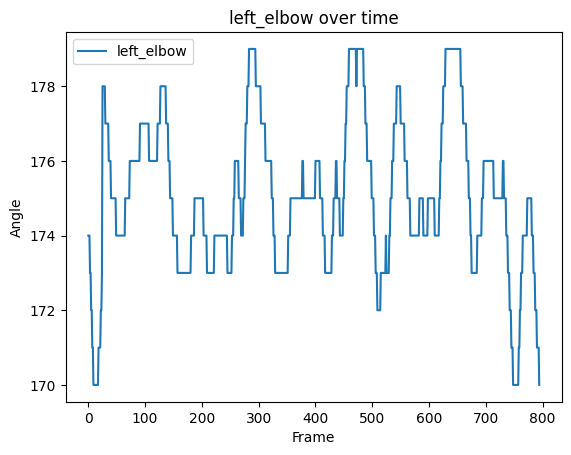

right_elbow: shape = (795,)


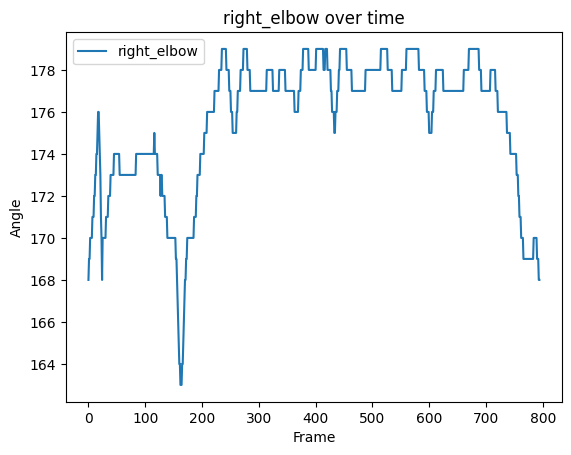

left_knee: shape = (795,)


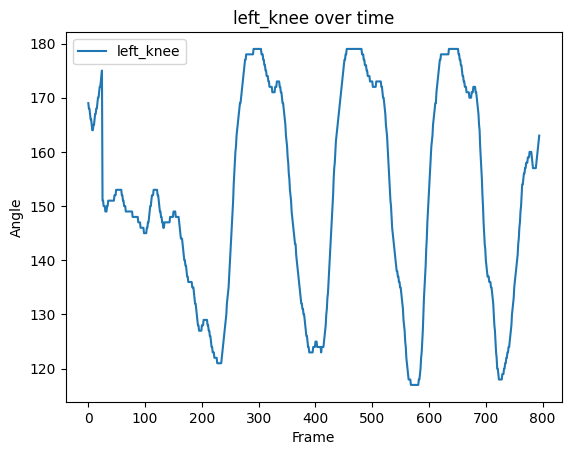

right_knee: shape = (795,)


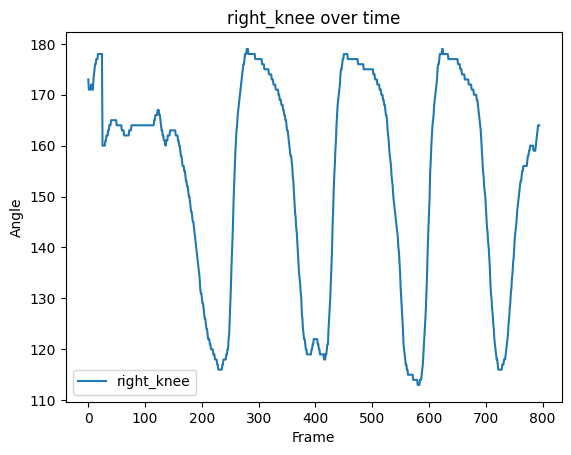

right_hip: shape = (795,)


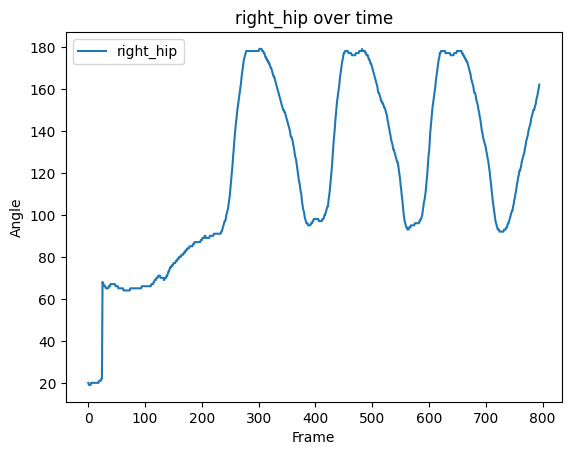

left_hip: shape = (795,)


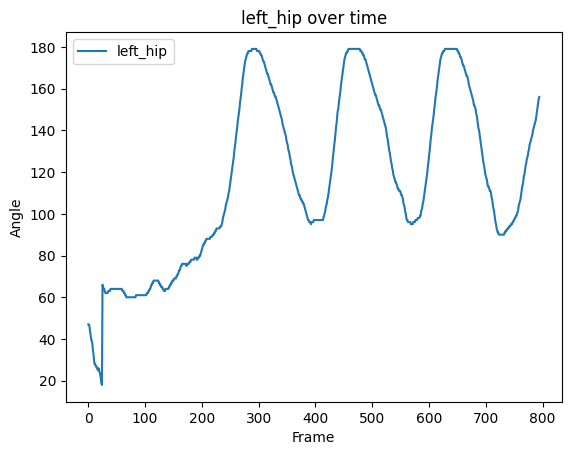

In [270]:
#NPZ VIEWING
import numpy as np
import matplotlib.pyplot as plt

data = np.load(r"C:\Users\alexk\PycharmProjects\SeniorProject\data\deadlift files\deadlift angles.npz")
for key in data:
    joint_data = data[key]
    print(f"{key}: shape = {joint_data.shape}")
    plt.plot(joint_data, label=key)
    plt.title(f"{key} over time")
    plt.xlabel("Frame")
    plt.ylabel("Angle")
    plt.legend()
    plt.show()
